In [ ]:
WITH equipos AS (
    SELECT 
        '%america-vs-guadalajara%' AS equipos1,
        '%' || SPLIT_PART('%america-vs-guadalajara%', '-vs-', 2) || '-vs-' || SPLIT_PART('%america-vs-guadalajara%', '-vs-', 1) || '%' AS equipos2,
        REPLACE(SPLIT_PART('%america-vs-guadalajara%', '-vs-', 1), '%', '') AS equipo1,
        REPLACE(SPLIT_PART('%america-vs-guadalajara%', '-vs-', 2), '%', '') AS equipo2
),
goles_equipo1 AS (
    SELECT 
        COALESCE(SUM(goles_local), 0) AS total_goles_local_pair1,
        COALESCE(SUM(goles_visita), 0) AS total_goles_visita_pair1
    FROM (
        SELECT 
            temporada, 
            equipos, 
            marcador, 
            TO_NUMBER(REPLACE(SUBSTR(TRIM(marcador), 1, 1), '-', '0'), '99') AS goles_local,
            TO_NUMBER(REPLACE(SUBSTR(TRIM(marcador), 5, 1), '-', '0'), '99') AS goles_visita
        FROM lbf_partidos_hist, equipos
        WHERE lbf_partidos_hist.equipos LIKE equipos.equipos1
    ) subquery
),
goles_equipo2 AS (
    SELECT 
        COALESCE(SUM(goles_local), 0) AS total_goles_local_pair2,
        COALESCE(SUM(goles_visita), 0) AS total_goles_visita_pair2
    FROM (
        SELECT 
            temporada, 
            equipos, 
            marcador, 
            TO_NUMBER(REPLACE(SUBSTR(TRIM(marcador), 1, 1), '-', '0'), '99') AS goles_local,
            TO_NUMBER(REPLACE(SUBSTR(TRIM(marcador), 5, 1), '-', '0'), '99') AS goles_visita
        FROM lbf_partidos_hist, equipos
        WHERE lbf_partidos_hist.equipos LIKE equipos.equipos2
    ) subquery
)
SELECT 
    e.equipo1,
    e.equipo2,
    g1.total_goles_local_pair1,
    g1.total_goles_visita_pair1,
    g2.total_goles_local_pair2,
    g2.total_goles_visita_pair2,
    (g1.total_goles_local_pair1 + g2.total_goles_visita_pair2) AS total_goles_equipo1,
    (g2.total_goles_local_pair2 + g1.total_goles_visita_pair1) AS total_goles_equipo2
FROM equipos e
CROSS JOIN goles_equipo1 g1
CROSS JOIN goles_equipo2 g2;



WITH equipos AS (
    SELECT 
        REPLACE(SPLIT_PART('%america-vs-guadalajara%', '-vs-', 1), '%', '') AS equipo1,
        REPLACE(SPLIT_PART('%america-vs-guadalajara%', '-vs-', 2), '%', '') AS equipo2
),
puntos_fair_play AS (
    SELECT 
        MIN(total_puntos) AS total_puntos_min,
        MAX(total_puntos) AS total_puntos_max
    FROM lbf_fair_play
),
equipo1_stats AS (
    SELECT 
        equipo1 AS equipo, 
        COALESCE(SUM(total_puntos), 0) AS total_puntos,
        COALESCE(SUM(tarjeta_amarilla), 0) AS tarjetas_amarillas,
        COALESCE(SUM(tarjeta_roja_x_segunda_amarilla + tarjeta_roja_directa), 0) AS tarjetas_rojas
    FROM lbf_fair_play, equipos
    WHERE lbf_fair_play.club ILIKE equipo1
    GROUP BY equipo1
),
equipo2_stats AS (
    SELECT 
        equipo2 AS equipo, 
        COALESCE(SUM(total_puntos), 0) AS total_puntos,
        COALESCE(SUM(tarjeta_amarilla), 0) AS tarjetas_amarillas,
        COALESCE(SUM(tarjeta_roja_x_segunda_amarilla + tarjeta_roja_directa), 0) AS tarjetas_rojas
    FROM lbf_fair_play, equipos
    WHERE lbf_fair_play.club ILIKE equipo2
    GROUP BY equipo2
)
SELECT 
    e1.equipo AS equipo1, e2.equipo AS equipo2,
    pf.total_puntos_min, pf.total_puntos_max,
    e1.total_puntos AS total_puntos_equipo1, e1.tarjetas_amarillas AS tarjetas_amarillas_equipo1, e1.tarjetas_rojas AS tarjetas_rojas_equipo1,
    e2.total_puntos AS total_puntos_equipo2, e2.tarjetas_amarillas AS tarjetas_amarillas_equipo2, e2.tarjetas_rojas AS tarjetas_rojas_equipo2
FROM puntos_fair_play pf
CROSS JOIN equipo1_stats e1
CROSS JOIN equipo2_stats e2;



WITH equipos AS (
    SELECT 
        REPLACE(SPLIT_PART('%América-vs-Guadalajara%', '-vs-', 1), '%', '') AS equipo1,
        REPLACE(SPLIT_PART('%América-vs-Guadalajara%', '-vs-', 2), '%', '') AS equipo2
),
historical_points AS (
    SELECT 
        club, 
        COALESCE(SUM(pts), 0) AS total_puntos_acumulados
    FROM lbf_historical_stats
    WHERE club ILIKE (SELECT equipo1 FROM equipos)
       OR club ILIKE (SELECT equipo2 FROM equipos)
    GROUP BY club
)
SELECT 
    (SELECT equipo1 FROM equipos) AS equipo1,
    (SELECT equipo2 FROM equipos) AS equipo2,
    MAX(CASE WHEN club ILIKE (SELECT equipo1 FROM equipos) THEN total_puntos_acumulados END) AS total_puntos_equipo1,
    MAX(CASE WHEN club ILIKE (SELECT equipo2 FROM equipos) THEN total_puntos_acumulados END) AS total_puntos_equipo2
FROM historical_points;


In [9]:
%pip install mplcyberpunk

Note: you may need to restart the kernel to use updated packages.


C:\Users\ShePlay\AppData\Local\Temp\ipykernel_10492\2583741569.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


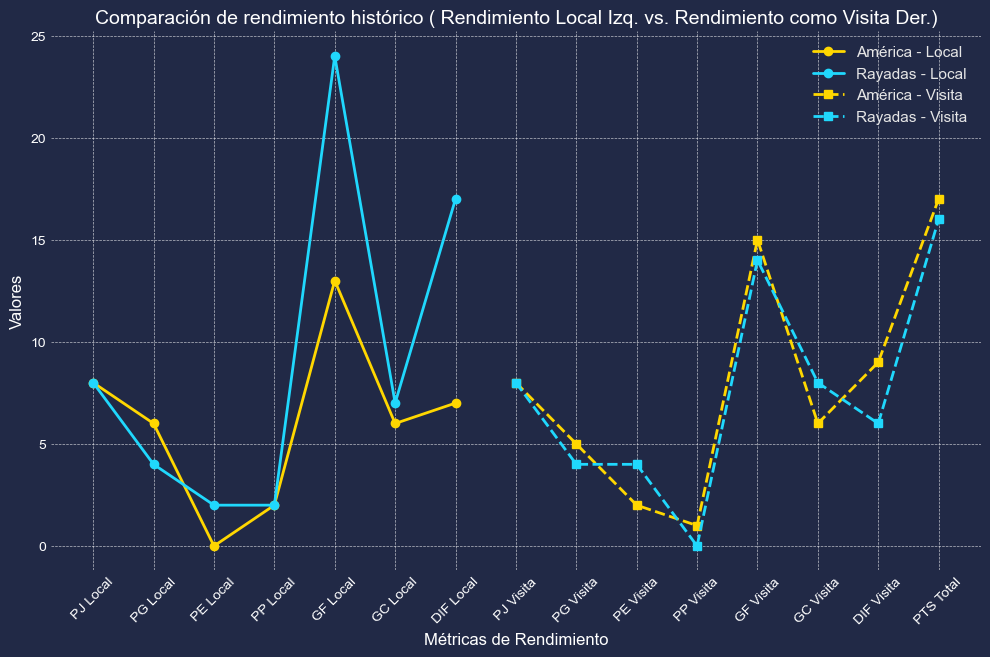

In [17]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import mplcyberpunk

# Parámetros de conexión a la base de datos
DB_PARAMS = {
    "dbname": "labasefemenil",
    "user": "marioruiz",
    "password": "welcome1",
    "host": "212.38.95.88",
    "port": "5432"
}

# Equipos a comparar
equipos1 = "América-vs-Rayadas"
equipo1, equipo2 = equipos1.split("-vs-")

# Consulta SQL para obtener datos históricos
query = f"""
    SELECT club, pts2, pts3, jj2, jj3, jg2, jg3, je2, je3, jp2, jp3, gf2, gf3, gc2, gc3, dif2, dif3
    FROM lbf_historical_stats
    WHERE club ILIKE '{equipo1}' OR club ILIKE '{equipo2}';
"""

# Conectar a PostgreSQL y ejecutar la consulta
try:
    with psycopg2.connect(**DB_PARAMS) as conn:
        df = pd.read_sql_query(query, conn)
except Exception as e:
    print(f"Error conectando a la base de datos: {e}")
    exit()

# Validar si se obtuvieron datos
if df.empty:
    print("Error: No se encontraron datos con la consulta proporcionada.")
    exit()

# Convertir nombres de equipos a minúsculas para comparación
df["club"] = df["club"].str.lower()

# Mapear nombres de columnas para hacerlos más comprensibles
column_map = {
    "jj2": "PJ Local", "jg2": "PG Local", "je2": "PE Local", "jp2": "PP Local",
    "gf2": "GF Local", "gc2": "GC Local", "dif2": "DIF Local",
    "jj3": "PJ Visita", "jg3": "PG Visita", "je3": "PE Visita", "jp3": "PP Visita",
    "gf3": "GF Visita", "gc3": "GC Visita", "dif3": "DIF Visita", "pts3": "PTS Total"
}

# Renombrar las columnas en el DataFrame
df.rename(columns=column_map, inplace=True)

# Separar datos por equipo
equipo1_data = df[df["club"] == equipo1.lower()]
equipo2_data = df[df["club"] == equipo2.lower()]

# Validar si ambos equipos tienen datos
if equipo1_data.empty or equipo2_data.empty:
    print("Error: Faltan datos para uno de los equipos.")
    exit()

# Lista de métricas a graficar
labels = [
    "PJ Local", "PG Local", "PE Local", "PP Local", "GF Local", "GC Local", "DIF Local",
    "PJ Visita", "PG Visita", "PE Visita", "PP Visita", "GF Visita", "GC Visita", "DIF Visita", "PTS Total"
]

# Extraer valores de cada equipo
equipo1_values = [equipo1_data[col].values[0] for col in labels]
equipo2_values = [equipo2_data[col].values[0] for col in labels]

# Configurar el tema oscuro
plt.style.use("cyberpunk")

# Generar el gráfico
plt.figure(figsize=(12, 7))

# Graficar datos de local (línea sólida)
plt.plot(labels[:7], equipo1_values[:7], marker="o", linestyle="-", color="#FFD700", linewidth=2, label=f"{equipo1} - Local")
plt.plot(labels[:7], equipo2_values[:7], marker="o", linestyle="-", color="#20d8fd", linewidth=2, label=f"{equipo2} - Local")

# Graficar datos de visita (línea discontinua)
plt.plot(labels[7:], equipo1_values[7:], marker="s", linestyle="--", color="#FFD700", linewidth=2, label=f"{equipo1} - Visita")
plt.plot(labels[7:], equipo2_values[7:], marker="s", linestyle="--", color="#20d8fd", linewidth=2, label=f"{equipo2} - Visita")

# Personalizar el gráfico
plt.xlabel("Métricas de Rendimiento", color="white", fontsize=12)
plt.ylabel("Valores", color="white", fontsize=12)
plt.title("Comparación de rendimiento histórico ( Rendimiento Local Izq. vs. Rendimiento como Visita Der.)", color="white", fontsize=14)
plt.legend(facecolor="blue", edgecolor="white", fontsize=11)
plt.xticks(rotation=45, color="white")
plt.yticks(color="white")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7, color="white")

# Mostrar gráfico
plt.show()
